In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model
from keras.models import load_model
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'


Using TensorFlow backend.
/home/yangtianyun/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yangtianyun/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yangtianyun/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yangtianyun/anaconda3/lib/python3.7

In [2]:
def _compute_gradients(tensor, var_list):
    grads = tf.gradients(tensor, var_list)
    return [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(var_list, grads)]

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

#https://github.com/jacobgil/keras-grad-cam/issues/17
def normalize(x):
#     utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def load_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.common.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def grad_cam2(input_model, image, category_index, layer_name):

    nb_classes = 2
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    x = Lambda(target_layer, output_shape = target_category_loss_output_shape)(input_model.output)
    model = Model(inputs=input_model.input, outputs=x)
#     model.summary()
    loss = K.sum(model.output)

    for l in model.layers:
        if l.name == layer_name:
            print(l.name)
    a=[l for l in model.layers if l.name == layer_name][0]
    conv_output=a.get_output_at(1) 
    print(conv_output.shape)
    
#     conv_output =  [l for l in model.layers if l.name == layer_name][0].output
    grads = normalize(_compute_gradients(loss, [conv_output])[0])
    gradient_function = K.function(model.input, [conv_output, grads])
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [57]:
path='/home/yangtianyun/Data/train/train_rumor/68c5a79e61430cae6139580917244e97.jpg'
# path='./examples/cat_dog.png'
modelpath='/home/yangtianyun/MM_course/models/checkpoint-09e-val_accuracy_0.8825.hdf5'
preprocessed_input = load_image(path)
model = load_model(modelpath)
predictions = model.predict(preprocessed_input)
predicted_class = np.argmax(predictions)
cam, heatmap = grad_cam2(model, preprocessed_input, predicted_class, "vgg19")

# register_gradient()
# guided_model = modify_backprop(model, 'GuidedBackProp')
# saliency_fn = compile_saliency_function(guided_model)
# saliency = saliency_fn([preprocessed_input, 0])
# gradcam = saliency[0] * heatmap[..., np.newaxis]

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
_________________________________________________________________
lambda_27 (Lambda)           (None, 2)                 0         
Total params: 20,025,410
Trainable params: 20,025,410
Non-trainable params: 0
______________________________________________

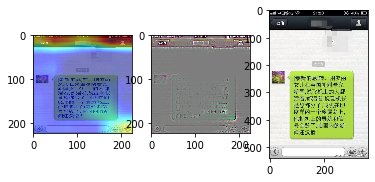

In [58]:
import matplotlib.pyplot as plt

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(cam, cv2.COLOR_BGR2RGB))
# plt.subplot(1,3,2)
# plt.imshow(deprocess_image(gradcam))
plt.subplot(1,3,2)
plt.imshow(plt.imread(path))

In [3]:
import os
import random

train_rumor_dir='/home/yangtianyun/Data/train/train_rumor/'
files_rumor=os.listdir(train_rumor_dir)
n_files_rumor=len(files_rumor)

train_nonrumor_dir='/home/yangtianyun/Data/train/train_nonrumor/'
files_nonrumor=os.listdir(train_nonrumor_dir)
n_files_nonrumor=len(files_nonrumor)

In [4]:
modelpath='/home/yangtianyun/MM_course/models/checkpoint-09e-val_accuracy_0.8825.hdf5'
model = load_model(modelpath)

def get_cam(imgpath):
    preprocessed_input = load_image(imgpath)
    predictions = model.predict(preprocessed_input)
    predicted_class = np.argmax(predictions)
    cam, heatmap = grad_cam2(model, preprocessed_input, predicted_class, "vgg19")
    return cam

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [9]:
import matplotlib.pyplot as plt

def show_random_cam(select):
    if select=='rumor':
        train_rumor_index=random.sample(range(n_files_rumor),10)
        for i in range(10):
            imgpath=train_rumor_dir+files_rumor[train_rumor_index[i]]
            print(imgpath)
            cam=get_cam(imgpath)
            plt.subplot(1,2,1)
            plt.imshow(cv2.cvtColor(cam, cv2.COLOR_BGR2RGB))
            plt.subplot(1,2,2)
            plt.imshow(plt.imread(imgpath))
            plt.pause(0.05)
    elif select=='nonrumor':
        train_nonrumor_index=random.sample(range(n_files_nonrumor),10)
        for i in range(10):
            imgpath=train_nonrumor_dir+files_nonrumor[train_nonrumor_index[i]]
            print(imgpath)
            cam=get_cam(imgpath)
            plt.subplot(1,2,1)
            plt.imshow(cv2.cvtColor(cam, cv2.COLOR_BGR2RGB))
            plt.subplot(1,2,2)
            plt.imshow(plt.imread(imgpath))
            plt.pause(0.05)

/home/yangtianyun/Data/train/train_rumor/c9a89310e4b89ddd9fdace105e6f343f.jpg
vgg19
(?, 7, 7, 512)


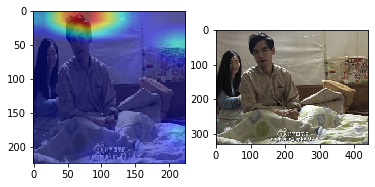

/home/yangtianyun/Data/train/train_rumor/23a9ecbd06c0bb11796806566a1752c3.jpg
vgg19
(?, 7, 7, 512)


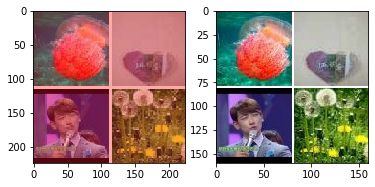

/home/yangtianyun/Data/train/train_rumor/f8b576042658d1df40786fdd0e13d2d2.jpg
vgg19
(?, 7, 7, 512)


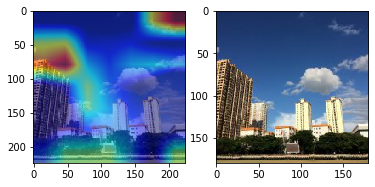

/home/yangtianyun/Data/train/train_rumor/4c72d28e07669fbda582a8646dcad0b0.jpg
vgg19
(?, 7, 7, 512)


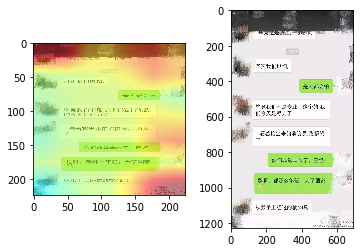

/home/yangtianyun/Data/train/train_rumor/f1f83c019c0e89c9eaa87e4205adbac5.jpg
vgg19
(?, 7, 7, 512)


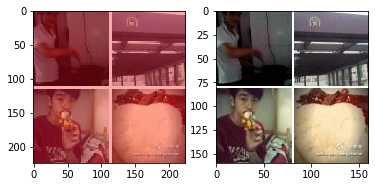

/home/yangtianyun/Data/train/train_rumor/ae52b6bf174381c1d8b972a66527d3fc.jpg
vgg19
(?, 7, 7, 512)


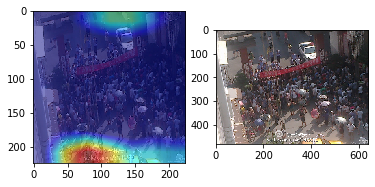

/home/yangtianyun/Data/train/train_rumor/5ccab5a75d8882525083046572575f34.jpg
vgg19
(?, 7, 7, 512)


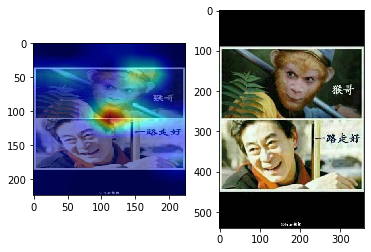

/home/yangtianyun/Data/train/train_rumor/a5179d1a70a10815fbc79bf71c7d5330.gif
vgg19
(?, 7, 7, 512)


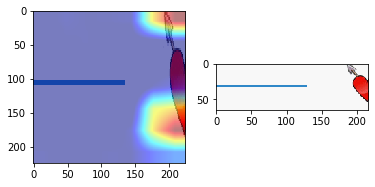

/home/yangtianyun/Data/train/train_rumor/f342e96e9647bf8d63e7d73e3ed10c7d.jpg
vgg19
(?, 7, 7, 512)


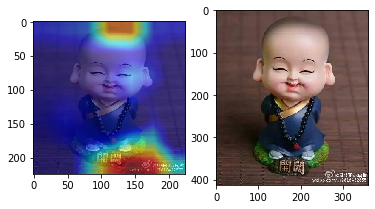

/home/yangtianyun/Data/train/train_rumor/99ec56af2923a369afbe6f00025342b9.jpg
vgg19
(?, 7, 7, 512)


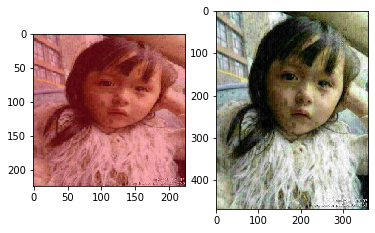

In [7]:
show_random_cam('rumor')

/home/yangtianyun/Data/train/train_nonrumor/fe5ed1b065037cb4ae7123fd2f17952d.jpg
vgg19
(?, 7, 7, 512)


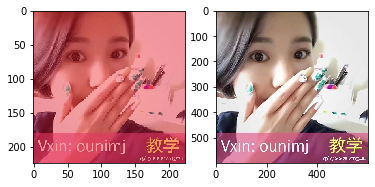

/home/yangtianyun/Data/train/train_nonrumor/f08b23951e636286275307c177de672e.jpg
vgg19
(?, 7, 7, 512)


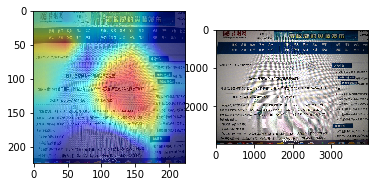

/home/yangtianyun/Data/train/train_nonrumor/3cd8e7a17f1ea193ecd5bef32eac897e.jpg
vgg19
(?, 7, 7, 512)


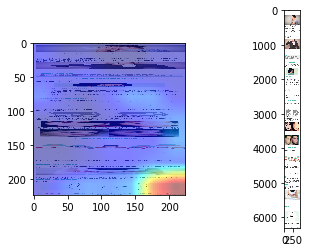

/home/yangtianyun/Data/train/train_nonrumor/e24915f9ba66afc2a3d9d912af6a1c2e.jpg
vgg19
(?, 7, 7, 512)


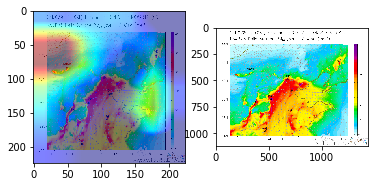

/home/yangtianyun/Data/train/train_nonrumor/b3d3e2b2d9904595fc25162161ffede6.jpg
vgg19
(?, 7, 7, 512)


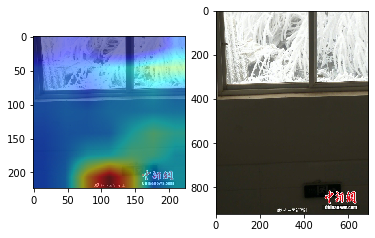

/home/yangtianyun/Data/train/train_nonrumor/77ee574f5399f5ef0ee03d8d8ced45ee.jpg
vgg19
(?, 7, 7, 512)


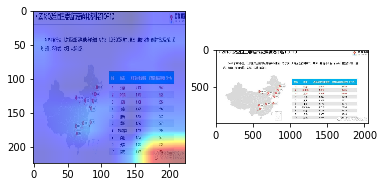

/home/yangtianyun/Data/train/train_nonrumor/31f8d48b59f0de28b5f2993a0ad69857.jpg
vgg19
(?, 7, 7, 512)


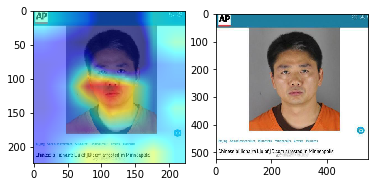

/home/yangtianyun/Data/train/train_nonrumor/a09c3bd291434520a3d7a85c6b7240ec.jpg
vgg19
(?, 7, 7, 512)


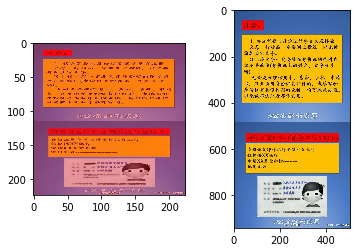

/home/yangtianyun/Data/train/train_nonrumor/2e5a7f3c88d4257772221c8bc527c12a.jpg
vgg19
(?, 7, 7, 512)


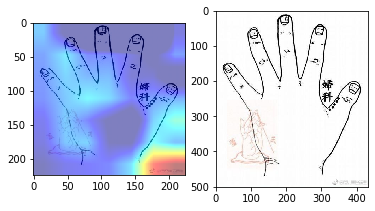

/home/yangtianyun/Data/train/train_nonrumor/b5ddfe29c8075e14542d42944a97287c.jpg
vgg19
(?, 7, 7, 512)


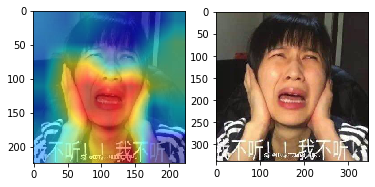

In [10]:
show_random_cam('nonrumor')